# Modelling the DEZEMBER alternation

## Fixed effects model

Used as a starting point to examine the relationship between predictor variables and the response variable.

### Importing libraries

In [1]:
library(lme4)
library(glue)
library(performance)
library(rstudioapi)
library(broom)
library(scales)
library(sjPlot)
library(ggplot2)
library(dplyr)
library(dplyr)
library(stargazer)
library(broom.mixed)

Lade nötiges Paket: Matrix


Attache Paket: ‘dplyr’


Die folgenden Objekte sind maskiert von ‘package:stats’:

    filter, lag


Die folgenden Objekte sind maskiert von ‘package:base’:

    intersect, setdiff, setequal, union



Please cite as: 


 Hlavac, Marek (2022). stargazer: Well-Formatted Regression and Summary Statistics Tables.

 R package version 5.2.3. https://CRAN.R-project.org/package=stargazer 




### Loading and preprocessing data

Treatment coding of response variable: "dezember " = 0, "zwölf" = 1

In [2]:
data <- read.csv("dezember_zwoelf_for_analysis.csv")
data$CURRENT <- as.factor(data$CURRENT)
data <- data %>% rename(PREVIOUS_BETA_ZWOELF = PREVIOUS_BETA_ZWÖLF)
cat("R models this level:", tail(levels(data$CURRENT), 1))

R models this level: zwoelf

In [3]:
#renaming speakers for consistency with the rest of the study
data <- data %>% mutate(PREVIOUS_SPEAKER = recode(PREVIOUS_SPEAKER, "A" = "VA", "S" = "HS"))

Combining the variables PREVIOUS and PREVIOUS_SPEAKER as modelling an interaction of these two independent variables leads to an issue of singularity

In [4]:
data$PREVIOUS_SPEAKER_COMBINED <- interaction(data$PREVIOUS, data$PREVIOUS_SPEAKER) #R automatically creates a factor
cat("Levels are:", levels(data$PREVIOUS_SPEAKER_COMBINED))

Levels are: dezember.HS zwoelf.HS dezember.VA zwoelf.VA

interaction() creates even combinations which never appear, here we discard them

In [5]:
data$PREVIOUS_SPEAKER_COMBINED <- droplevels(data$PREVIOUS_SPEAKER_COMBINED)
#before renaming (see above) "dezember.A" was the reference level as it is first in alphabetical order, 
#to preserve this even after renaming, the factor is relevelled 
data$PREVIOUS_SPEAKER_COMBINED <- relevel(data$PREVIOUS_SPEAKER_COMBINED, ref = "dezember.VA")
cat("The reference level of PREVIOUS_SPEAKER_COMBINED is:", head(levels(data$PREVIOUS_SPEAKER_COMBINED), 1)) 

The reference level of PREVIOUS_SPEAKER_COMBINED is: dezember.VA

Treatment coding of further predictor variables

In [6]:
data$PREVIOUS_BETA_ZWOELF <- as.factor(data$PREVIOUS_BETA_ZWOELF) 
data$QUASI_PERSISTENCE <- as.factor(data$QUASI_PERSISTENCE) 
data$CONFEDERATE <- as.factor(data$CONFEDERATE) 

### Data inspection

Overview of the data

In [7]:
head(data)

,X,CURRENT,PREVIOUS,PREVIOUS_SPEAKER,PREVIOUS_DISTANCE,PREVIOUS_DISTANCE_LOG,PREVIOUS_BETA_ZWOELF,PREVIOUS_BETA_DEZEMBER,QUASI_PERSISTENCE,HUMAN_ID,INTERACTION_ID,TURN_LENGTH,CONFEDERATE,PREVIOUS_SPEAKER_COMBINED
,<int>,<fct>,<chr>,<chr>,<int>,<dbl>,<fct>,<chr>,<fct>,<chr>,<int>,<int>,<fct>,<fct>
1,125,zwoelf,dezember,VA,86,4.454347,False,False,False,20171121A,1,32,False,dezember.VA
2,338,dezember,dezember,VA,38,3.637586,False,False,False,20171121A,1,26,False,dezember.VA
3,353,dezember,dezember,HS,15,2.708050,True,False,False,20171121A,1,26,False,dezember.HS
4,388,dezember,dezember,HS,35,3.555348,False,False,True,20171121A,1,37,False,dezember.HS
5,406,dezember,dezember,HS,18,2.890372,True,False,False,20171121A,1,37,False,dezember.HS
6,420,dezember,dezember,HS,14,2.639057,False,False,False,20171121A,1,37,False,dezember.HS


Distribution of choices in CURRENT

In [8]:
data %>% count(CURRENT)

CURRENT,n
<fct>,<int>
dezember,131
zwoelf,543


Distribution of PREVIOUS

In [9]:
data %>% count(PREVIOUS_SPEAKER_COMBINED)

PREVIOUS_SPEAKER_COMBINED,n
<fct>,<int>
dezember.VA,471
dezember.HS,43
zwoelf.HS,160


### Model fitting

In [35]:
fixed_effects_model <- glm(CURRENT ~ PREVIOUS_SPEAKER_COMBINED * PREVIOUS_DISTANCE_LOG + 
                                     PREVIOUS_SPEAKER_COMBINED * QUASI_PERSISTENCE +
                                     PREVIOUS_BETA_ZWOELF,
                                     data = data, family = 'binomial')

summary(fixed_effects_model)


Call:
glm(formula = CURRENT ~ PREVIOUS_SPEAKER_COMBINED * PREVIOUS_DISTANCE_LOG + 
    PREVIOUS_SPEAKER_COMBINED * QUASI_PERSISTENCE + PREVIOUS_BETA_ZWOELF, 
    family = "binomial", data = data)

Coefficients:
                                                           Estimate Std. Error
(Intercept)                                                  3.3034     0.9621
PREVIOUS_SPEAKER_COMBINEDdezember.HS                        -7.1684     1.9489
PREVIOUS_SPEAKER_COMBINEDzwoelf.HS                          -1.7894     2.1151
PREVIOUS_DISTANCE_LOG                                       -0.4313     0.2147
QUASI_PERSISTENCETrue                                       -0.2154     0.3114
PREVIOUS_BETA_ZWOELFTrue                                    -0.5477     0.2448
PREVIOUS_SPEAKER_COMBINEDdezember.HS:PREVIOUS_DISTANCE_LOG   1.1119     0.5053
PREVIOUS_SPEAKER_COMBINEDzwoelf.HS:PREVIOUS_DISTANCE_LOG     1.2250     0.7179
PREVIOUS_SPEAKER_COMBINEDdezember.HS:QUASI_PERSISTENCETrue   1.5377     0.886

#### Model evaluation

In [36]:
#Events per predictor
events <- sum(data$CURRENT == "dezember") #Number of positive cases
predictors <- length(coef(fixed_effects_model)) - 1 #Exclude intercept
EPP <- events / predictors
print(EPP)

[1] 14.55556


In [37]:
r2_nagelkerke(fixed_effects_model)
AIC(fixed_effects_model)

Nagelkerke's R2 
      0.2783547

[1] 554.7004

Model evaluation using predictive efficiency comparing how well the model fares at predicting the data it was fitted on compared to a 'dumb' intercept-only model only ever predicting the most frequent outcome

In [38]:
#Predictive efficiency
fixed_model_predictions <- predict(fixed_effects_model, newdata = data, type = "response")
#Convert probabilities to binary outcomes (i.e., if probability > 0.5, predict 1, else 0)
fixed_model_predicted_class <- ifelse(fixed_model_predictions > 0.5, "zwoelf", "dezember")
#Compare predicted values to actual values
fixed_model_accuracy <- mean(fixed_model_predicted_class == data$CURRENT)
fixed_model_accuracy

[1] 0.8442136

In [39]:
#Calculate baseline accuracy, i.e., a dumb intercept-only model only ever predicting the most frequent outcome
counts <- table(data$CURRENT) 
dumb_model_accuracy <- max(counts) / sum(counts)
dumb_model_accuracy

[1] 0.805638

In [40]:
#McNemar's Test for significance against baseline
baseline_predicted_class <- rep(names(which.max(counts)), length(data$CURRENT))  #Create baseline predictions (always predict the most frequent outcome)
mcnemar_table <- table(
  model_correct = (fixed_model_predicted_class == data$CURRENT),
  baseline_correct = (baseline_predicted_class == data$CURRENT)) #Create a contingency table: Compare model and baseline predictions against actual values
mcnemar_result <- mcnemar.test(mcnemar_table) #Perform McNemar's Test
mcnemar_result


	McNemar's Chi-squared test with continuity correction

data:  mcnemar_table
McNemar's chi-squared = 14.881, df = 1, p-value = 0.0001145


#### Visualisation

Plot visualises the probability of observing "zwoelf" in CURRENT given different combinations of variants in PREVIOUS and SPEAKERS.

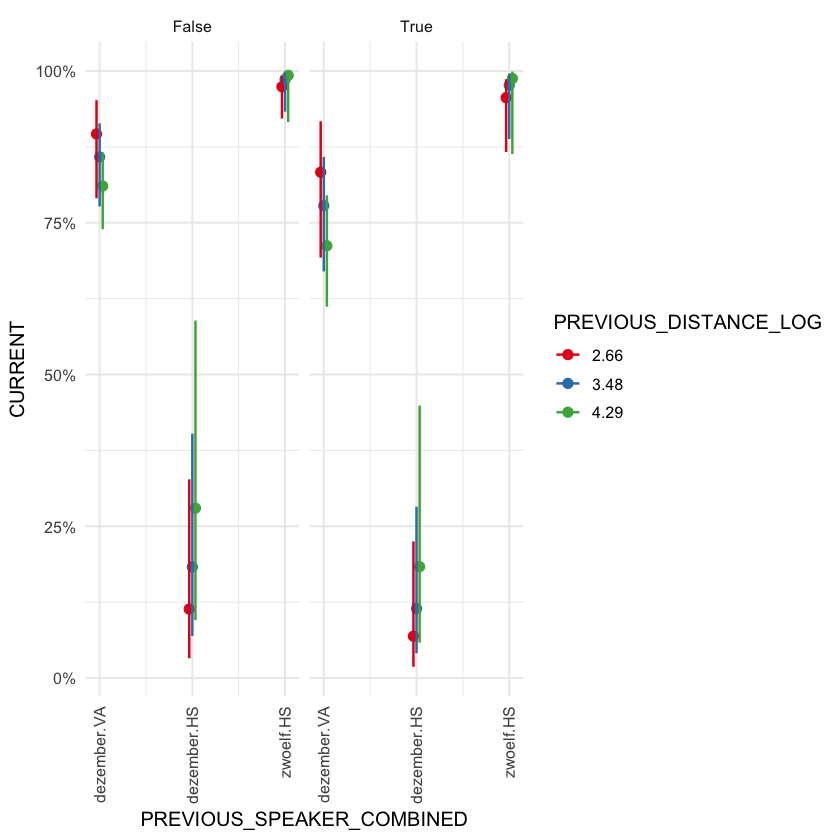

In [41]:
#for "zwölf" in CURRENT
plot <- plot_model(fixed_effects_model, type="pred", terms=c("PREVIOUS_SPEAKER_COMBINED", "PREVIOUS_DISTANCE_LOG", "PREVIOUS_BETA_ZWOELF"), dpi=300) +
        theme(axis.text = element_text(size = 16), axis.title = element_text(size = 16)) +
        theme(scale_y_continuous(limits = c(0, 1))) + theme_minimal(base_size=12) +
        theme(plot.title = element_blank()) +
        theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))
ggsave("../../../publication/further/images/coefficient_plot_DEZEMBER_fixed.png", plot, width = 8, height = 6, dpi = 300)
plot

### Output

In [42]:
tab_model(fixed_effects_model, auto.label = FALSE, transform = NULL, show.aic = TRUE, dv.labels = c("Simple model without random effect"), file = "../../../publication/further/tables/simple_model_DEZEMBER.html")

## Mixed model

### Model fitting

In [7]:
mixed_model_with_interaction <- glmer(CURRENT ~ PREVIOUS_SPEAKER_COMBINED * PREVIOUS_DISTANCE_LOG + 
                                      PREVIOUS_BETA_ZWOELF +
                                      (1 | HUMAN_ID), 
                                      data = data, family = binomial)

summary(mixed_model_with_interaction)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: CURRENT ~ PREVIOUS_SPEAKER_COMBINED * PREVIOUS_DISTANCE_LOG +  
    PREVIOUS_BETA_ZWOELF + (1 | HUMAN_ID)
   Data: data

     AIC      BIC   logLik deviance df.resid 
   317.6    353.7   -150.8    301.6      666 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-9.7382  0.0224  0.0541  0.1445  4.1599 

Random effects:
 Groups   Name        Variance Std.Dev.
 HUMAN_ID (Intercept) 15.98    3.998   
Number of obs: 674, groups:  HUMAN_ID, 27

Fixed effects:
                                                           Estimate Std. Error
(Intercept)                                                 5.59624    1.56626
PREVIOUS_SPEAKER_COMBINEDdezember.HS                       -5.78328    2.14478
PREVIOUS_SPEAKER_COMBINEDzwoelf.HS                         -0.02319    2.15566
PREVIOUS_DISTANCE_LOG                                      -0.37706    0.27502
PRE

In [8]:
mixed_model_without_interaction <- glmer(CURRENT ~ PREVIOUS_SPEAKER_COMBINED * QUASI_PERSISTENCE +
                                         PREVIOUS_BETA_ZWOELF + 
                                         (1 | HUMAN_ID), 
                                         data = data, family = binomial)

summary(mixed_model_without_interaction)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: 
CURRENT ~ PREVIOUS_SPEAKER_COMBINED * QUASI_PERSISTENCE + PREVIOUS_BETA_ZWOELF +  
    (1 | HUMAN_ID)
   Data: data

     AIC      BIC   logLik deviance df.resid 
   319.0    355.1   -151.5    303.0      666 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-7.6795  0.0241  0.0585  0.1560  3.3787 

Random effects:
 Groups   Name        Variance Std.Dev.
 HUMAN_ID (Intercept) 15.94    3.993   
Number of obs: 674, groups:  HUMAN_ID, 27

Fixed effects:
                                                           Estimate Std. Error
(Intercept)                                                 3.80135    1.15255
PREVIOUS_SPEAKER_COMBINEDdezember.HS                       -1.82305    0.67443
PREVIOUS_SPEAKER_COMBINEDzwoelf.HS                          1.81047    0.70069
QUASI_PERSISTENCETrue                                       0.53231    0.39863
PREVIO

In [12]:
library(car)
vif(mixed_model_without_interaction)

Lade nötiges Paket: carData


Attache Paket: ‘car’


Das folgende Objekt ist maskiert ‘package:dplyr’:

    recode




,GVIF,Df,GVIF^(1/(2*Df))
PREVIOUS_SPEAKER_COMBINED,2.302543,2,1.231833
QUASI_PERSISTENCE,1.277183,1,1.130125
PREVIOUS_BETA_ZWOELF,1.034886,1,1.017293
PREVIOUS_SPEAKER_COMBINED:QUASI_PERSISTENCE,2.417771,2,1.246964


Coefficient plot

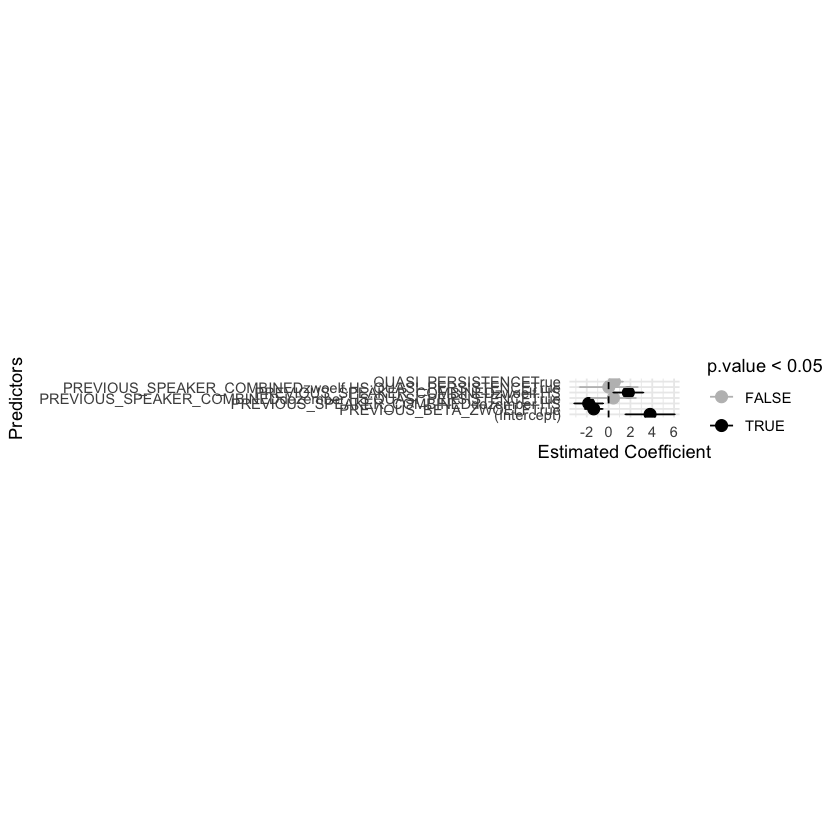

In [13]:
model_summary <- tidy(mixed_model_without_interaction, conf.int = TRUE) %>% filter(effect == "fixed")  #Include only fixed effects

plot <- ggplot(model_summary, aes(x = estimate, y = term, color = p.value < 0.05)) +
          geom_point(size = 3) +
          geom_errorbarh(aes(xmin = conf.low, xmax = conf.high), height = 0.2) +  
          geom_vline(xintercept = 0, linetype = "dashed") +
          labs(
            x = "Estimated Coefficient",
            y = "Predictors",
          ) +
          theme_minimal() +
          scale_color_manual(values = c("TRUE" = "black", "FALSE" = "gray")) +  #Grey out non-significant predictors
          coord_fixed(ratio = 0.5)

ggsave("../../../publication/further/images/coefficient_plot_DEZEMBER.png", width = 10, height = 4,
       plot = plot, dpi = 300, bg = "white")

plot

#### Model evaluation 

In [14]:
r2(mixed_model_with_interaction)
AIC(mixed_model_with_interaction)

r2(mixed_model_without_interaction)
AIC(mixed_model_without_interaction)

# R2 for Mixed Models

  Conditional R2: 0.841
     Marginal R2: 0.068

[1] 317.5529

# R2 for Mixed Models

  Conditional R2: 0.840
     Marginal R2: 0.067

[1] 319.0295

Given the substantially improved fit and AIC compared to the fixed effects model, checking whether there are enough data points per group of HUMAN_ID, as too low a number could lead to overfitting.

In [15]:
table(data$HUMAN_ID) 
mean(table(data$HUMAN_ID)) #more than 20 per group which is recommended
sd(table(data$HUMAN_ID))
length(unique(data$HUMAN_ID)) #slightly below rule of thumb of 30 groups


20171121A 20171121B 20171121C 20171122A 20171122B 20171122C 20171123A 20171123B 
       15        17        37        12        24        18        27         9 
20171123D 20171123E 20171123F 20171127A 20171127B 20171127C 20171128A 20171128B 
       26        21        30        22        26        20        24        33 
20171129A 20171129B 20171129C 20171129D 20171130A 20171130B 20171130C 20171201A 
       32        29        33        15        31        34        29        18 
20171201B 20171208A 20171208B 
       41        29        22 

[1] 24.96296

[1] 7.895868

[1] 27

Also plotting the random effects to see if there are anomalies

In [16]:
#Extract random effects
random_effects <- ranef(mixed_model)$HUMAN_ID
random_effects_df <- as.data.frame(random_effects)
colnames(random_effects_df) <- c("Intercept")
ggplot(random_effects_df, aes(x = Intercept)) +
  geom_histogram(binwidth = 0.5, fill = "blue", color = "black", alpha = 0.7) +
  theme_minimal() +
  labs(title = "Distribution of Random Effects (HUMAN_ID)",
       x = "Random Intercept",
       y = "Frequency") #not perfectly normal, but not extremely skewed either

ERROR: Error: Objekt 'mixed_model' nicht gefunden


##### Leave-one-out cross validation

Fitting models with one data point left out at each time, then having the models predict the left-out data point. Finally, seeing how well the models predict unseen data, giving an estimate of model performance.

In [50]:
predictions <- numeric(nrow(data)) #vector for storing predictions

#Iterating over dataset
for (i in 1:nrow(data)) {
    print(i)
    
    train_data <- data[-i, ] #creating 'train_data' which leaves out the current data point

    #fitting model on 'train_data'
    model_loo <- glmer(CURRENT ~ PREVIOUS_SPEAKER_COMBINED * QUASI_PERSISTENCE +
                       PREVIOUS_BETA_ZWOELF + 
                       (1 | HUMAN_ID), 
                       data = train_data, family = binomial)

    #checking if model converged, if yes (messages are NULL)...
    if (is.null(model_loo@optinfo$conv$lme4$messages)) {
        #having 'model_loo' predict the current data point and storing it in 'predictions'
        predictions[i] <- predict(model_loo, newdata = data[i, , drop = FALSE], type = "response")
    } else { 
        predictions[i] <- NA #if not, storing NA (otherwise R fills 'predictions' for missing indices with 0 which, however, could also be a probability)
        }
}

Checking in how many cases no prediction could be made as the model did not converge on the remaining data points, filtering for valid predictions only.

In [ ]:
sum(is.na(predictions))
filtered_predictions <- predictions[!is.na(predictions)] 

Extracting the ground truth and filtering for values where a prediction could be made as a model was successfully fitted on the remaining data points. 

In [ ]:
actuals <- data$CURRENT
filtered_actuals <- actuals[!is.na(predictions)] 
length(filtered_actuals) == length(filtered_predictions)

Replacing probabilities in `filtered_predictions` such that values above 0.5 mean "zwoelf" was predicted ("zwoelf" is the modelled level) and values below mean "dezember" was predicted instead.

In [ ]:
predicted_class <- ifelse(filtered_predictions > 0.5, "zwoelf", "dezember")
predicted_class

Comparing ground truth with predicted class for each data point and calculating mean.

In [ ]:
mean(filtered_actuals == predicted_class)

While this approach is not ideal as not all models would converge, it still provides a robust estimate of model performance, as contrary to predictive efficiency as calculated above, it indicates how well the models generalise to unseen data.  

Model evaluation using predictive efficiency comparing how well the model fares at predicting the data if was fitted on compared to a 'dumb' intercept-only model only ever predicting the most frequent outcome

In [28]:
#Predictive efficiency
mixed_model_predictions <- predict(mixed_model_without_interaction, newdata = data, type = "response")
#Convert probabilities to binary outcomes (i.e., if probability > 0.5, predict 1, else 0)
mixed_model_predicted_class <- ifelse(mixed_model_predictions > 0.5, "zwoelf", "dezember")
#Compare predicted values to actual values
mixed_model_accuracy <- mean(mixed_model_predicted_class == data$CURRENT)
mixed_model_accuracy

[1] 0.9332344

In [29]:
#Calculate baseline accuracy, i.e., a dumb intercept-only model only ever predicting the most frequent outcome
counts <- table(data$CURRENT) 
dumb_model_accuracy <- max(counts) / sum(counts)
dumb_model_accuracy

[1] 0.805638

In [30]:
#McNemar's Test for significance against baseline
baseline_predicted_class <- rep(names(which.max(counts)), length(data$CURRENT))  #Create baseline predictions (always predict the most frequent outcome)
mcnemar_table <- table(
  model_correct = (mixed_model_predicted_class == data$CURRENT),
  baseline_correct = (baseline_predicted_class == data$CURRENT)) #Create a contingency table: Compare model and baseline predictions against actual values
mcnemar_result <- mcnemar.test(mcnemar_table) #Perform McNemar's Test
mcnemar_result


	McNemar's Chi-squared test with continuity correction

data:  mcnemar_table
McNemar's chi-squared = 62.284, df = 1, p-value = 2.973e-15


In [31]:
#McNemar's Test for significance against fixed effects model
baseline_predicted_class <- rep(names(which.max(counts)), length(data$CURRENT))  #Create baseline predictions (always predict the most frequent outcome)
mcnemar_table <- table(
  mixed_model_correct = (mixed_model_predicted_class == data$CURRENT),
  fixed_model_correct = (fixed_model_predicted_class == data$CURRENT)) #Create a contingency table: Compare model and baseline predictions against actual values
mcnemar_result <- mcnemar.test(mcnemar_table) #Perform McNemar's Test
mcnemar_result


	McNemar's Chi-squared test with continuity correction

data:  mcnemar_table
McNemar's chi-squared = 42.451, df = 1, p-value = 7.247e-11


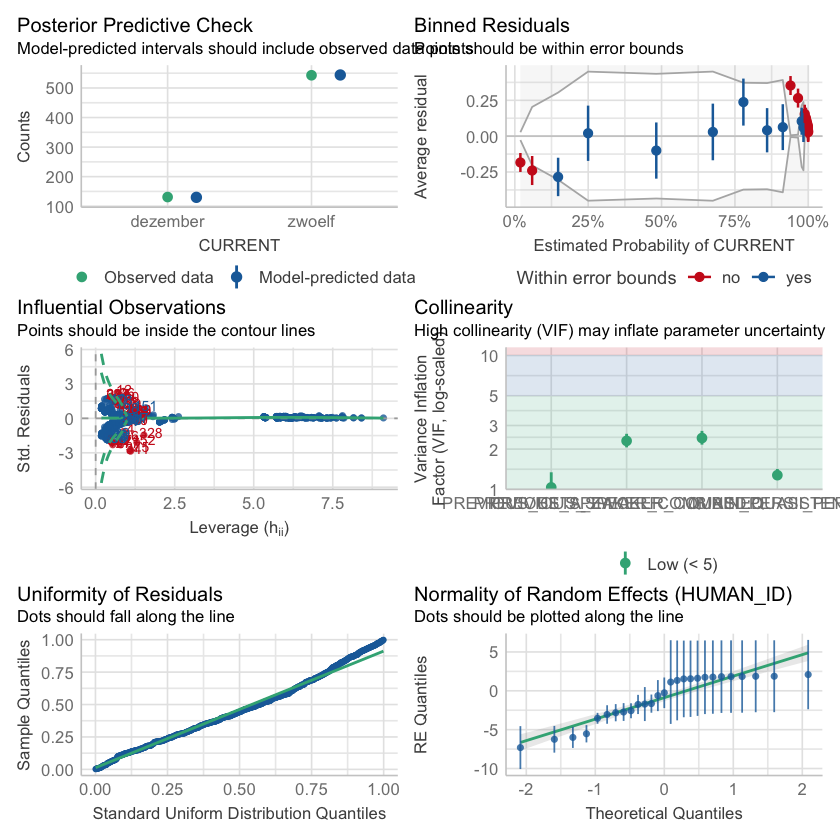

In [32]:
check_model(mixed_model_without_interaction)

### Refitting the model 

Including only significant predictors to facilitate manual predictions

In [ ]:
#refitting model with only the (marginally) significant predictors, making predictions easier
mixed_model_reduced <- glmer(CURRENT ~ PREVIOUS_SPEAKER_COMBINED +
                               PREVIOUS_BETA_ZWOELF +
                               (1 | HUMAN_ID),
                       data = data, family = binomial)

summary(mixed_model_reduced)

In [39]:
model_summary <- tidy(mixed_model_reduced) %>% filter(effect == "fixed")  # Include only fixed effects

plot <- ggplot(model_summary, conf.int = TRUE, aes(x = estimate, y = term)) +
          geom_point(size = 3) +
          geom_errorbarh(aes(xmin = estimate - std.error, 
                             xmax = estimate + std.error), 
                         height = 0.2) +
          geom_vline(xintercept = 0, linetype = "dashed") +
          labs(
            x = "Estimated Coefficient",
            y = "Predictors",
          ) +
          theme_minimal() +
          coord_fixed(ratio = 0.5)

ggsave("../../../publication/further/images/coefficient_plot_DEZEMBER.png", width = 10, height = 4,
       plot = plot, dpi = 300, bg = "white")
plot

ERROR: Error: Objekt 'mixed_model_reduced' nicht gefunden


#### Model evaluation

In [ ]:
r2(mixed_model_reduced)
AIC(mixed_model_reduced)

#### Predictions

In [ ]:
#prediction for both outcomes and different values in PREVIOUS_SPEAKER_COMBINED
PREVIOUS_SPEAKER_COMBINED_values <- list("zwoelf.S", "dezember.S", "dezember.A")
predicted_outcomes <- list("zwoelf" = 0,
                           "dezember" = 1)

#random effects are excluded (re.form = NA), so we get population-level predictions
for (outcome in names(predicted_outcomes)) {
  conversion <- predicted_outcomes[[outcome]]
  for (value in PREVIOUS_SPEAKER_COMBINED_values) {
    if (substr(value, nchar(value), nchar(value)) == "S") {
      insert_values_beta_False <- data.frame(
        PREVIOUS_SPEAKER_COMBINED = value,
        PREVIOUS_BETA_ZWOELF = "False",
        HUMAN_ID = "20171121A")
      prob_beta_False <- predict(mixed_model_reduced, newdata = insert_values_beta_False, type = "response", re.form = NA)
      insert_values_beta_True <- data.frame(
        PREVIOUS_SPEAKER_COMBINED = value,
        PREVIOUS_BETA_ZWOELF = "True",
        HUMAN_ID = "20171121A")
      prob_beta_True <- predict(mixed_model_reduced, newdata = insert_values_beta_True, type = "response", re.form = NA)
      cat("If the human speaker previously produced '", 
                  substr(value, 1, nchar(value) - 2), 
                  "', the model predicts that the probability of observing '",
                  outcome,
                  "' in CURRENT is ", 
                  abs(conversion - round(prob_beta_False, 2)), " (without β-trigger) and ",
                  abs(conversion - round(prob_beta_True, 2)),
                  " (with β-trigger).\n\n", sep = "")
    } else {
      insert_values_beta_False <- data.frame(
        PREVIOUS_SPEAKER_COMBINED = value,
        PREVIOUS_BETA_ZWOELF = "False",
        HUMAN_ID = "20171121A")
      prob_beta_False <- predict(mixed_model_reduced, newdata = insert_values_beta_False, type = "response", re.form = NA)
      insert_values_beta_True <- data.frame(
        PREVIOUS_SPEAKER_COMBINED = value,
        PREVIOUS_BETA_ZWOELF = "True",
        HUMAN_ID = "20171121A")
      prob_beta_False <- predict(mixed_model_reduced, newdata = insert_values_beta_True, type = "response", re.form = NA)
      cat("If the voice assistant previously produced '", 
                  substr(value, 1, nchar(value) - 2), 
                  "', the model predicts that the probability of observing '",
                  outcome,
                  "' in CURRENT is ", 
                  abs(conversion - round(prob_beta_False, 2)), " (without β-trigger) and ",
                  abs(conversion - round(prob_beta_True, 2)),
                  " (with β-trigger).\n\n", sep = "")
    }
  }
}

#### Visualisation

Plot visualises the probability of observing "zwoelf" in CURRENT given different combinations of variants in PREVIOUS and SPEAKERS.

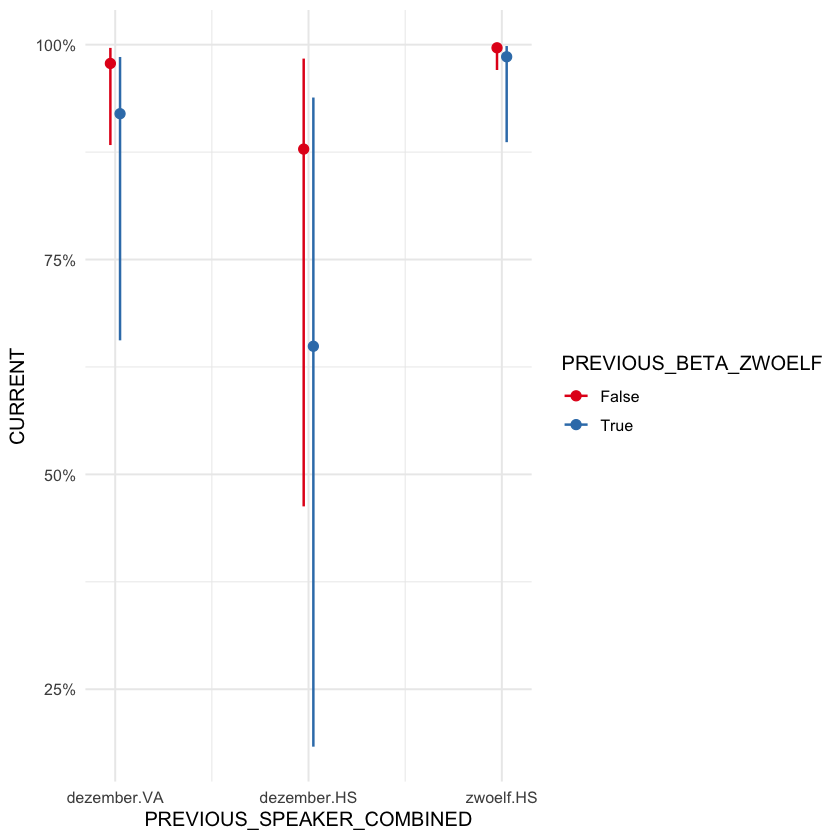

In [17]:
#for "zwölf" in CURRENT
plot <- plot_model(mixed_model_without_interaction, type="pred", terms=c("PREVIOUS_SPEAKER_COMBINED", "PREVIOUS_BETA_ZWOELF"), 
        dpi=300, group = "HUMAN_ID") +
        theme(scale_y_continuous(limits = c(0, 1))) + theme_minimal(base_size=12) +
        theme(plot.title = element_blank()) 
ggsave("../../../publication/further/images/prediction_plot_DEZEMBER.png", plot = plot, width = 8, height = 6, dpi = 300)
plot

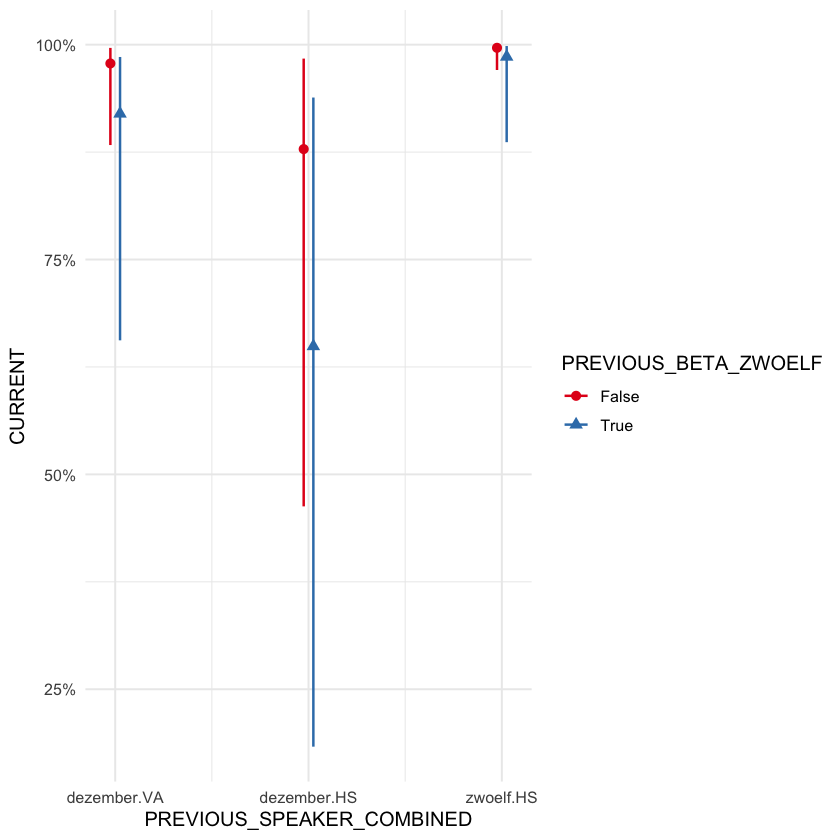

In [22]:
#for "zwölf" in CURRENT
plot <- plot_model(mixed_model_without_interaction, type = "pred", 
                   terms = c("PREVIOUS_SPEAKER_COMBINED", "PREVIOUS_BETA_ZWOELF"), 
                   group = "HUMAN_ID", dpi = 300)

plot <- plot +
    aes(color = as.factor(group), shape = as.factor(group)) +
    scale_shape_manual(values = c(16, 17)) +
    guides(color = guide_legend(title = "PREVIOUS_BETA_ZWOELF"),
    shape = guide_legend(title = "PREVIOUS_BETA_ZWOELF")) +
    theme_minimal(base_size = 12) +
    theme(plot.title = element_blank(),
          legend.position = "right")

ggsave("../../../publication/further/images/prediction_plot_DEZEMBER.png", 
       plot = plot, width = 8, height = 6, dpi = 300)

plot

### Output

In [9]:
tab_model(mixed_model_with_interaction, mixed_model_without_interaction, auto.label = FALSE, transform = NULL, show.aic = TRUE, dv.labels = c("Initial mixed-effects model", "Final mixed-effects model"), file = "../../../publication/further/tables/mixed_model_DEZEMBER.html")